# Modelos usando el algoritmo de vecinos más cercanos (KNN)

### Importación de bibliotecas

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import train_test_split
import sklearn as skl

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import preprocessing
import informe

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

### Llamado a funciones de preprocesamiento
- Dada la alta complejidad espacial del algortimo de knn, se realizará el entrenamiento con el 20% de los datos y la validación final con el 80% 

In [3]:
df = preprocessing.remove_irrelevant_features(df)
df = preprocessing.missings_treatment(df)
df = preprocessing.one_hot_encodding(df)

# Se separa el dataset en entrenamiento y holdout
X_train, X_holdout, y_train, y_holdout = preprocessing.dataset_split(df, test_size=0.80)

### Seteo de conjuntos de hiperparametros por los que se iterará en la busqueda de la mejor combinación

In [4]:
n_neighbors = range(10,36)
weights = ['uniform', 'distance']
metric = ['minkowski', 'cosine']
params = {'weights': weights, 'metric': metric, 'n_neighbors': n_neighbors}

### Modelos

#### Modelo 1
- Se usan todos los feautures, en su forma numérica, sin modificar

In [4]:
modelo1 = KNeighborsClassifier()

rscv = RandomizedSearchCV(
    modelo1, params, n_iter=35, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print("Resultados modelo 1")
print(f"    Mejores hiperparámetros: {rscv.best_params_}")
print(f"    Métrica AUC ROC: {rscv.best_score_:.2f}")

modelo1 = rscv.best_estimator_

Resultados modelo 1
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 17, 'metric': 'minkowski'}
    Métrica AUC ROC: 0.87


#### Modelo 2
- Se usan todos los features normalizados,
- para eso, se construye una clase estimadora siguiendo las reglas de sklearn por cuestiones de compatibilidad

In [5]:
# construyo un estmiador con las reglas de sklearn
class KNN_normalizado(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, weights='uniform', metric='minkowski'): 
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        
    def fit(self, X_train, y_train):

        self.normalizer = skl.preprocessing.Normalizer()
        X_train_n = self.normalizer.fit(X_train).transform(X_train)

        self.knn = KNeighborsClassifier(n_neighbors = self.n_neighbors, weights = self.weights, metric = self.metric) 
        self.knn.fit(X_train_n, y_train)

        return self

    def predict(self, X_pred):
        X_pred_n = self.normalizer.transform(X_pred)
        return self.knn.predict(X_pred_n)
    
    def predict_proba(self, X_pred):
        X_pred_n = self.normalizer.transform(X_pred)
        return self.knn.predict_proba(X_pred_n)

In [6]:
modelo2 = KNN_normalizado()

rscv = RandomizedSearchCV(
    modelo2, params, n_iter=35, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print("Resultados modelo 2")
print(f"    Mejores hiperparámetros: {rscv.best_params_}")
print(f"    Métrica AUC ROC: {rscv.best_score_:.2f}")

modelo2 = rscv.best_estimator_

Resultados modelo 2
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 20, 'metric': 'cosine'}
    Métrica AUC ROC: 0.85


#### Modelo 3
- El algoritmo de knn es afectado por features irrelevantes, se propone entonces aplicar alguna técnica de reducción dimensional
- Con los features relevantes, se construye un modelo análogo al modelo 1, es decir con los features sin normalizar

In [5]:
print(f'Features totales: {len(X_train.columns)}')

features_relevantes = preprocessing.embedded(X_train, y_train).columns

print(f'Features relevantes: {len(features_relevantes)}')

X_train_reducido = X_train[features_relevantes]
X_holdout_reducido = X_holdout[features_relevantes]

Features totales: 43
Features relevantes: 4


In [6]:
modelo3 = KNeighborsClassifier()

rscv = RandomizedSearchCV(
    modelo3, params, n_iter=35, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train_reducido, y_train)

print("Resultados modelo 3")
print(f"    Mejores hiperparámetros: {rscv.best_params_}")
print(f"    Métrica AUC ROC: {rscv.best_score_:.2f}")

modelo3 = rscv.best_estimator_

Resultados modelo 3
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 18, 'metric': 'minkowski'}
    Métrica AUC ROC: 0.89


#### Modelo 4
- Con los features relevantes, se construye un modelo análogo al modelo 2, es decir con los features normalizados

In [9]:
modelo4 = KNN_normalizado()

rscv = RandomizedSearchCV(
    modelo4, params, n_iter=35, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train_reducido, y_train)

print("Resultados modelo 4")
print(f"    Mejores hiperparámetros: {rscv.best_params_}")
print(f"    Métrica AUC ROC: {rscv.best_score_:.2f}")

modelo4 = rscv.best_estimator_

Resultados modelo 4
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 27, 'metric': 'minkowski'}
    Métrica AUC ROC: 0.86


### Conclusión
      En base a la metrica AUC-ROC se elige el modelo 3
      
### Informe del modelo 3 usando los datos del test_holdout

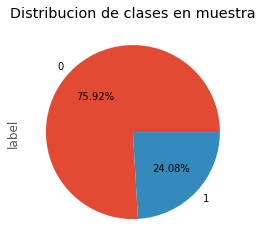

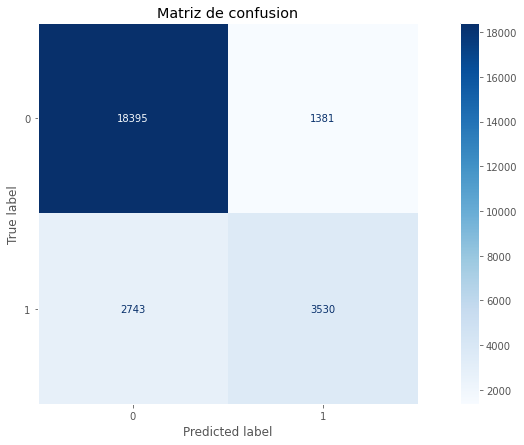

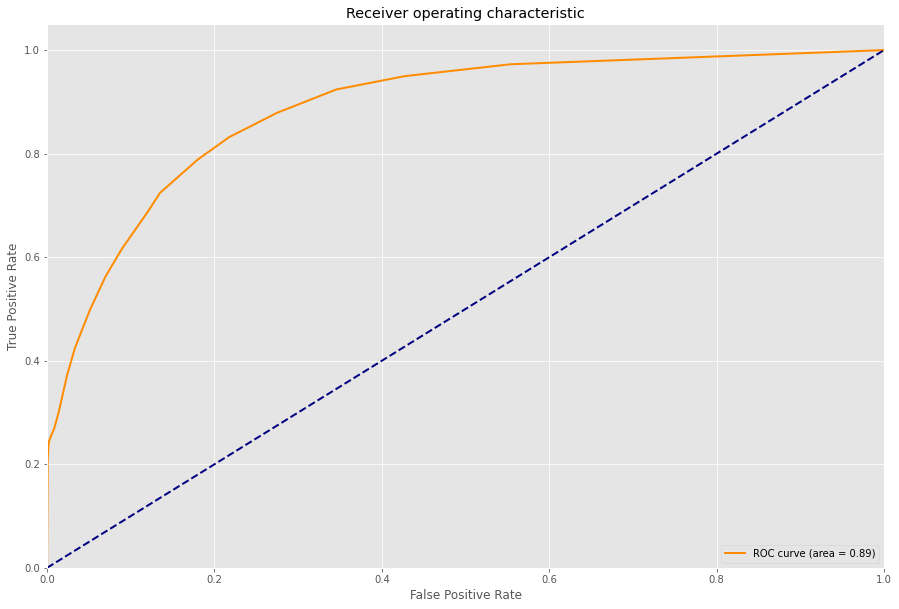

Métricas:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19776
           1       0.72      0.56      0.63      6273

    accuracy                           0.84     26049
   macro avg       0.79      0.75      0.77     26049
weighted avg       0.83      0.84      0.83     26049



In [8]:
informe.imprimir_informe(modelo3, X_holdout_reducido, y_holdout)

### Conclusiones de las métricas observadas de los datos de test_holdout

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 84%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        La fracción de predicciones de 0's que realmente eran 0's fue de aproximadamente 87% y la fracción de predicciones de 1's que realmente eran 1's fue del 72% 


- recall:

        Los 0's reales detectados fueron aproximadamente el 93%, y los 1's reales detectados fueron del 56%. Viendo este resultado en conjunto con la precisión, se entiende que el modelo es mejor prediciendo los 0's que los 1's 


- f1 score:
   
       La calidad del modelo es de 83% en terminos del recall y la precision asi como el balance entre ambas
       
       
- matriz de confusion:

        Se puede ver que las predicciones mayoritarias caen en la diagonal principal, lo cual es una buena caracteristica de una matriz de confusión. sin embargo para los 1's, las dos columnas estan demasiado balanceadas, lo cual ya se sabia ya que en el resultado de recall para los 1's no era muy bueno.
        Aproximadamente el 84% de las instancias se encuentran en la diagonal principal, (lo cual ya sabiamos por el accuracy del 84%)
        
        
- UAC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases en un 89%. Este valor será utilizado para decidir sobre la elección de este modelo.
